In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import skew
import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv("car details v4.csv")  # path to your dataset
print("Shape of Data:", df.shape)
print("\nFirst 5 Rows:\n", df.head())

print("\nColumn Names:", df.columns.tolist())

Shape of Data: (2059, 20)

First 5 Rows:
             Make                            Model    Price  Year  Kilometer  \
0          Honda              Amaze 1.2 VX i-VTEC   505000  2017      87150   
1  Maruti Suzuki                  Swift DZire VDI   450000  2014      75000   
2        Hyundai             i10 Magna 1.2 Kappa2   220000  2011      67000   
3         Toyota                         Glanza G   799000  2019      37500   
4         Toyota  Innova 2.4 VX 7 STR [2016-2020]  1950000  2018      69000   

  Fuel Type Transmission   Location   Color   Owner Seller Type   Engine  \
0    Petrol       Manual       Pune    Grey   First   Corporate  1198 cc   
1    Diesel       Manual   Ludhiana   White  Second  Individual  1248 cc   
2    Petrol       Manual    Lucknow  Maroon   First  Individual  1197 cc   
3    Petrol       Manual  Mangalore     Red   First  Individual  1197 cc   
4    Diesel       Manual     Mumbai    Grey   First  Individual  2393 cc   

            Max Power     

In [5]:
df = df.dropna()
print(df.shape)

(1874, 20)


In [6]:
print(df.head())

            Make                            Model    Price  Year  Kilometer  \
0          Honda              Amaze 1.2 VX i-VTEC   505000  2017      87150   
1  Maruti Suzuki                  Swift DZire VDI   450000  2014      75000   
2        Hyundai             i10 Magna 1.2 Kappa2   220000  2011      67000   
3         Toyota                         Glanza G   799000  2019      37500   
4         Toyota  Innova 2.4 VX 7 STR [2016-2020]  1950000  2018      69000   

  Fuel Type Transmission   Location   Color   Owner Seller Type   Engine  \
0    Petrol       Manual       Pune    Grey   First   Corporate  1198 cc   
1    Diesel       Manual   Ludhiana   White  Second  Individual  1248 cc   
2    Petrol       Manual    Lucknow  Maroon   First  Individual  1197 cc   
3    Petrol       Manual  Mangalore     Red   First  Individual  1197 cc   
4    Diesel       Manual     Mumbai    Grey   First  Individual  2393 cc   

            Max Power              Max Torque Drivetrain  Length   W

In [7]:
duplicate_count = df.duplicated().sum()
print(f"\n🔍 Number of duplicate rows: {duplicate_count}")



🔍 Number of duplicate rows: 0


In [8]:
print("\n📊 Statistical Summary:\n", df.describe())


📊 Statistical Summary:
               Price         Year     Kilometer       Length        Width  \
count  1.874000e+03  1874.000000  1.874000e+03  1874.000000  1874.000000   
mean   1.718279e+06  2016.713447  5.317814e+04  4281.512807  1767.886339   
std    2.426090e+06     3.138477  5.878833e+04   436.220747   131.344883   
min    4.900000e+04  1988.000000  0.000000e+00  3099.000000  1475.000000   
25%    5.000000e+05  2015.000000  2.801975e+04  3985.000000  1695.000000   
50%    8.424995e+05  2017.000000  4.879750e+04  4360.000000  1770.000000   
75%    1.908250e+06  2019.000000  7.100000e+04  4620.000000  1831.000000   
max    3.500000e+07  2022.000000  2.000000e+06  5569.000000  2220.000000   

            Height  Seating Capacity  Fuel Tank Capacity  
count  1874.000000       1874.000000         1874.000000  
mean   1588.967983          5.295091           52.217343  
std     134.627659          0.807008           15.167250  
min    1213.000000          2.000000           15.0000

Year → Skewness: -0.80


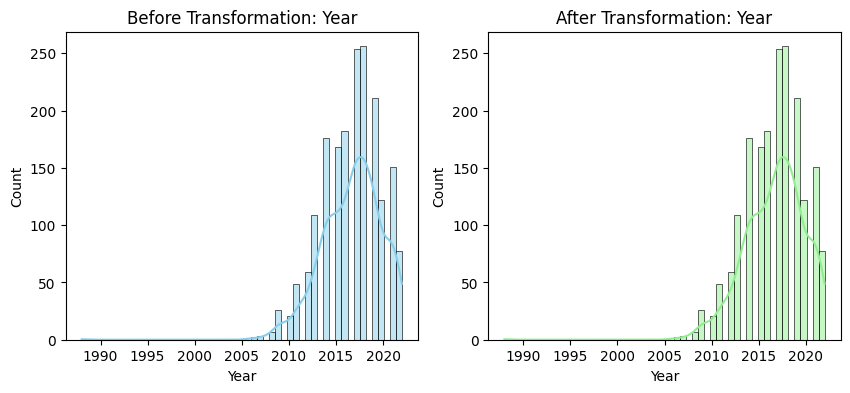

Kilometer → Skewness: 21.41
→ Kilometer transformed using Yeo-Johnson


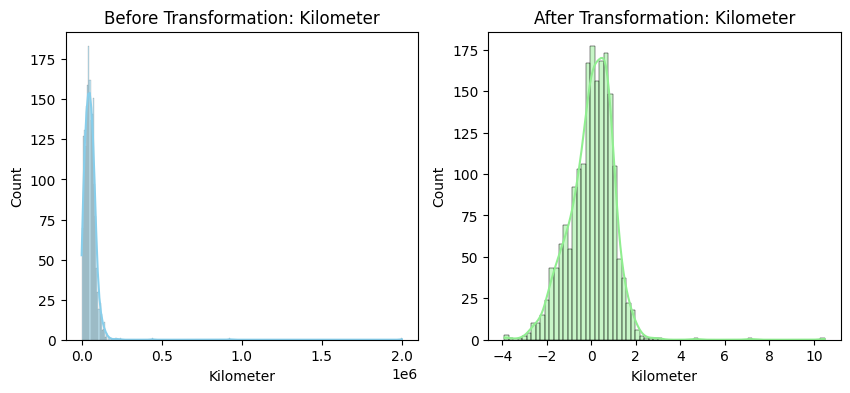

Length → Skewness: 0.00


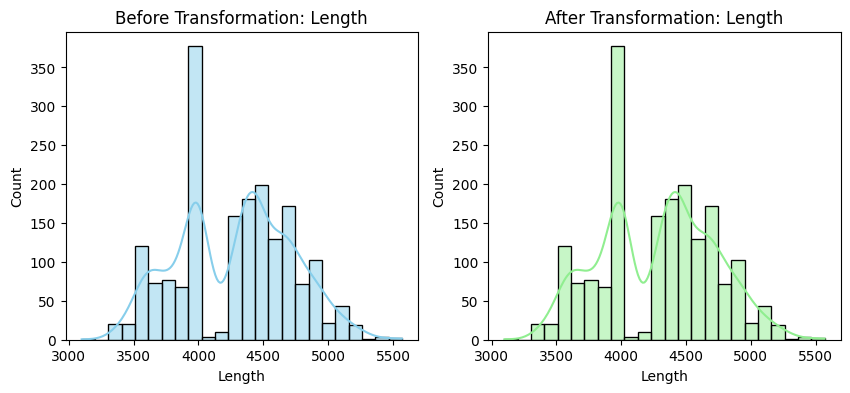

Width → Skewness: 0.36


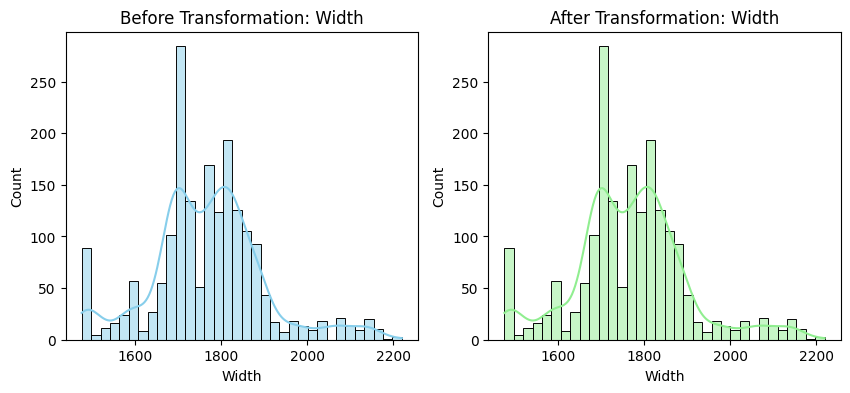

Height → Skewness: 0.91


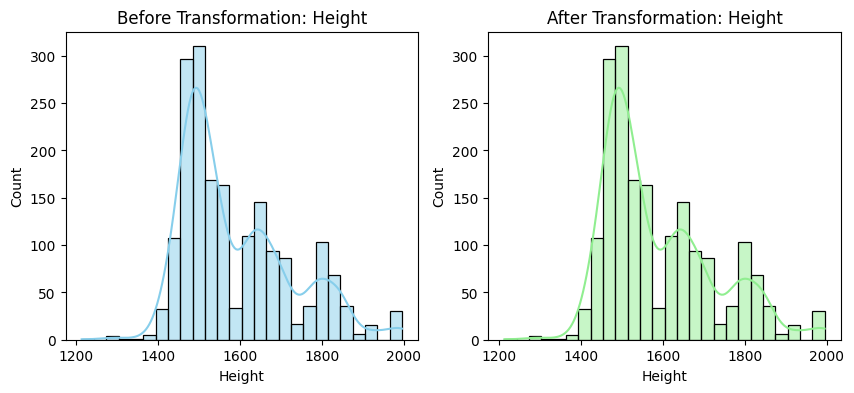

Seating Capacity → Skewness: 1.53
→ Seating Capacity transformed using Yeo-Johnson


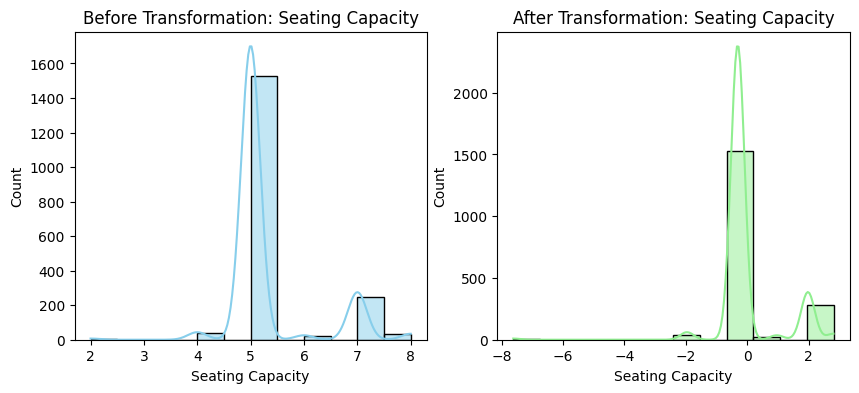

Fuel Tank Capacity → Skewness: 0.85


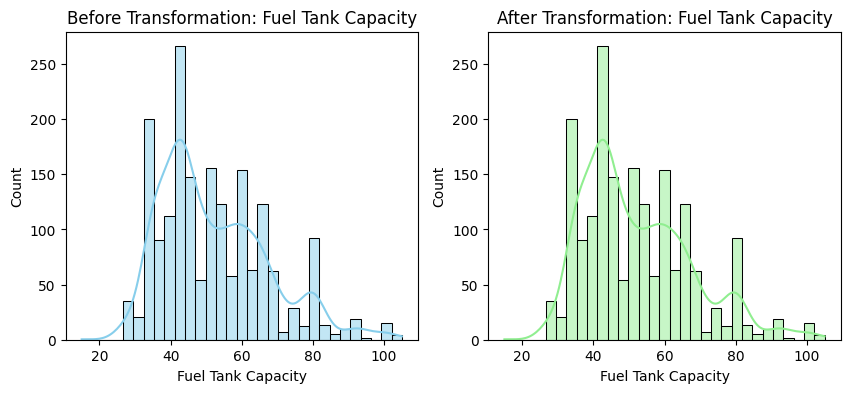

In [9]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop('Price')
for col in numeric_cols:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f"Before Transformation: {col}")
    
    # Check skewness
    skew = df[col].skew()
    print(f"{col} → Skewness: {skew:.2f}")

    # Apply transformation if not normal
    if abs(skew) > 1:
        pt = PowerTransformer(method='yeo-johnson')
        df[col] = pt.fit_transform(df[[col]]).flatten()
        print(f"→ {col} transformed using Yeo-Johnson")

    plt.subplot(1,2,2)
    sns.histplot(df[col], kde=True, color='lightgreen')
    plt.title(f"After Transformation: {col}")
    plt.show()

    

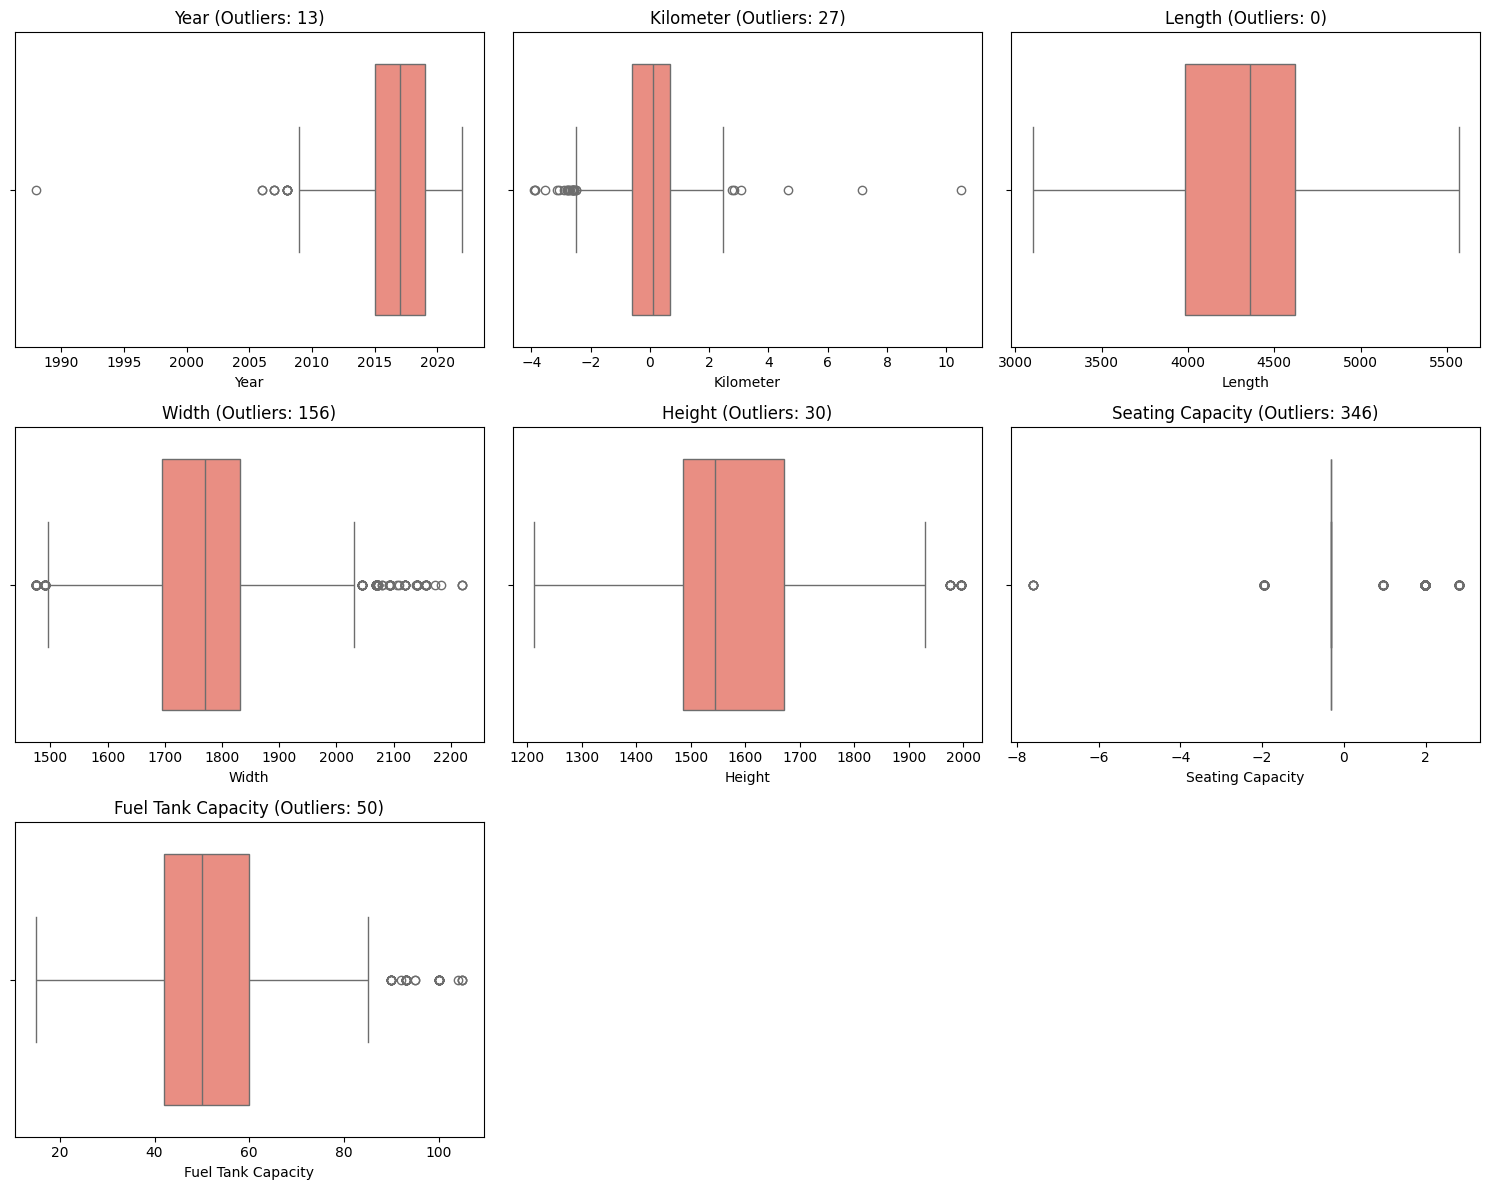


Outlier Summary (number of outliers per feature):
 {'Year': 13, 'Kilometer': 27, 'Length': 0, 'Width': 156, 'Height': 30, 'Seating Capacity': 346, 'Fuel Tank Capacity': 50}


In [10]:
n_cols = 3  # number of subplot columns
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # compute rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()  # flatten in case of multiple rows

outlier_summary = {}
for i, col in enumerate(numeric_cols):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary[col] = len(outliers)
    
    sns.boxplot(x=df[col], color='salmon', ax=axes[i])
    axes[i].set_title(f"{col} (Outliers: {len(outliers)})")

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("\nOutlier Summary (number of outliers per feature):\n", outlier_summary)

In [11]:
df = pd.read_csv("car details v4.csv") 
from sklearn.preprocessing import LabelEncoder

for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# THEN split
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
print("🔍 Checking for NaNs in the dataset...\n")
print(df.isna().sum())

# Total NaNs in the dataset
print("\nTotal missing values:", df.isna().sum().sum())


🔍 Checking for NaNs in the dataset...

Make                    0
Model                   0
Price                   0
Year                    0
Kilometer               0
Fuel Type               0
Transmission            0
Location                0
Color                   0
Owner                   0
Seller Type             0
Engine                  0
Max Power               0
Max Torque              0
Drivetrain              0
Length                 64
Width                  64
Height                 64
Seating Capacity       64
Fuel Tank Capacity    113
dtype: int64

Total missing values: 369


In [12]:
# 🧹 Fill missing numeric columns with median and categorical with mode
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\n✅ All missing values filled successfully.")
print(df.isna().sum().sum(), "missing values remaining.")



✅ All missing values filled successfully.
0 missing values remaining.


In [13]:
print("🔎 Any NaNs in X_train?", X_train.isna().sum().sum())
print("🔎 Any NaNs in X_test?", X_test.isna().sum().sum())
print("🔎 Any NaNs in y_train?", y_train.isna().sum())
print("🔎 Any NaNs in y_test?", y_test.isna().sum())


🔎 Any NaNs in X_train? 298
🔎 Any NaNs in X_test? 71
🔎 Any NaNs in y_train? 0
🔎 Any NaNs in y_test? 0


In [14]:
print("🔍 Columns with NaNs in X_train:\n", X_train.columns[X_train.isna().any()].tolist())
print("\nNaN count per column:\n", X_train.isna().sum()[X_train.isna().sum() > 0])


🔍 Columns with NaNs in X_train:
 ['Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']

NaN count per column:
 Length                52
Width                 52
Height                52
Seating Capacity      52
Fuel Tank Capacity    90
dtype: int64


In [15]:
# ✅ Fill missing numeric columns with median
numeric_nan_cols = ['Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']

for col in numeric_nan_cols:
    median_val = X_train[col].median()
    X_train[col].fillna(median_val, inplace=True)
    X_test[col].fillna(median_val, inplace=True)

# ✅ Verify all NaNs are gone
print("NaNs remaining in X_train:", X_train.isna().sum().sum())
print("NaNs remaining in X_test:", X_test.isna().sum().sum())


NaNs remaining in X_train: 0
NaNs remaining in X_test: 0


In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

print("🚀 Training Gradient Boosting Model...")
grid_search.fit(X_train, y_train)

print("\n✅ Best Parameters:", grid_search.best_params_)
print("✅ Best R² Score:", grid_search.best_score_)

🚀 Training Gradient Boosting Model...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
✅ Best R² Score: 0.8742481123666519


In [17]:
best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation Results:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


📊 Model Evaluation Results:
RMSE: 994056.13
R² Score: 0.859


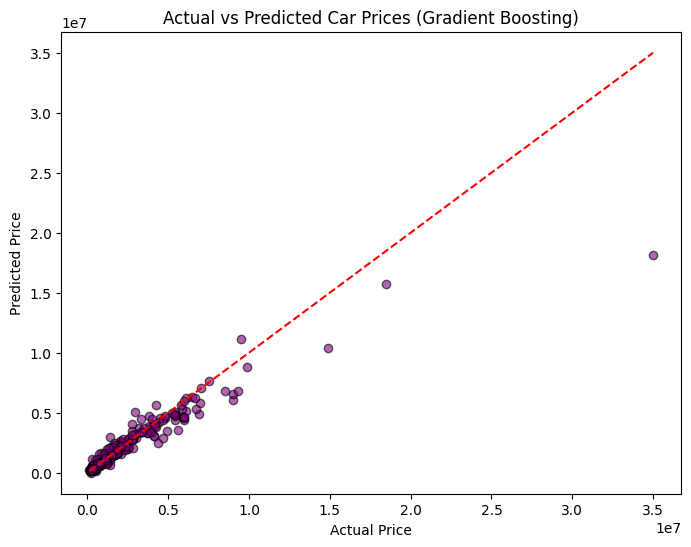

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices (Gradient Boosting)")
plt.show()